# EXTRA CREDIT - Weather Data

### import all libraries required

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from keras.utils import to_categorical
from tensorflow.keras.models import load_model,Sequential
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.optimizers import RMSprop, SGD, adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Using TensorFlow backend.


#### Load the data 

In [2]:
!cp /content/drive/My\ Drive/ECE542_sp20_CompetitionData/TrainData-C2/ExtraCredit_Train.csv /content/
train_df = pd.read_csv('ExtraCredit_Train.csv')

!cp /content/drive/My\ Drive/ECE542_sp20_CompetitionData/TrainData-C2/ExtraCredit_Test.csv /content/
test_df = pd.read_csv('ExtraCredit_Test.csv')

X_train = train_df.iloc[:,2:]
X_test = test_df.iloc[:,2:]
Y_train = train_df.iloc[:,1]
Y_test = test_df.iloc[:,1]

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(620, 12) (100, 12) (620,) (100,)


## 1. Predictions using tabular data only

#### Data Normalization

In [3]:
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(X_train.values) 
X_train = pd.DataFrame(x_scaled, index = X_train.index)

x_scaled = std_scaler.transform(X_test.values) 
X_test = pd.DataFrame(x_scaled, index = X_test.index)

print(X_train.shape,X_test.shape)
print(np.bincount(Y_train))

(620, 12) (100, 12)
[338 149  30  36  67]


#### PCA Feature Selection 

In [4]:
# Implementation of PCA
pca_dict = {}
eigen_dict = {}
for n_comp in range(10):
  pca = PCA(n_components=n_comp)
  temp_train_pca = pca.fit_transform(X_train)
  temp_test_pca = pca.transform(X_test)
  eigen_values = pca.explained_variance_[:n_comp]
  
  if n_comp > 0:
    #print (n_comp,pca.explained_variance_ratio_.sum(),eigen_values)[-1])
    pca_dict[n_comp] = pca.explained_variance_ratio_.sum()
    eigen_dict[n_comp] = eigen_values[-1]

# Selecting components with Eigen value greater than 1 from the list
#pca_comp_eigen = max([key for key,val in eigen_dict.items() if val >= 1])
pca_comp_eigen = max([key for key,val in pca_dict.items() if val < 0.95])

print('Components from Feature selection using PCA (Having Eigen values >=1)- ' + str(pca_comp_eigen) + '\n')

# Performing PCA for the train data with the fixed components
pca = PCA(n_components=pca_comp_eigen)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Feature Selection using PCA complete for the train data.\n\n')

Components from Feature selection using PCA (Having Eigen values >=1)- 5

Feature Selection using PCA complete for the train data.




### Support Vector Machine - Grid Search on parameters

In [5]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:
    
    clf = SVC(max_iter=100000, kernel=kernal, C=cval, class_weight='balanced')

    clf.fit(X_train_pca, Y_train)
    accuracy[kernal].append(clf.score(X_test_pca, Y_test))
    yPred = clf.predict(X_test_pca)

    del clf
    del yPred

print('\n\nSVM Accuracies: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(accuracy['linear']),4)) + ' for critical factor ' + str(c_list[accuracy['linear'].index(max(accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(accuracy['rbf']),4)) + ' for critical factor ' + str(c_list[accuracy['rbf'].index(max(accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(accuracy['poly']),4)) + ' for critical factor ' + str(c_list[accuracy['poly'].index(max(accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(accuracy['sigmoid']),4)) + ' for critical factor ' + str(c_list[accuracy['sigmoid'].index(max(accuracy['sigmoid']))]) +'\n\n')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)




SVM Accuracies: 
Linear kernal has maximum accuracy - 0.49 for critical factor 10

Radial Basis Function Kernel SVM accuracy - 0.72 for critical factor 1

Polynomial Kernel SVM has maximum accuracy - 0.66 for critical factor 1000

Sigmoid Kernel SVM has maximum accuracy - 0.39 for critical factor 0.1




### Best SVM model 

In [6]:
clf = SVC(max_iter=100000, kernel='rbf', C=1, class_weight='balanced')

clf.fit(X_train_pca, Y_train)

yPred = clf.predict(X_test_pca)
yPred_decision = clf.decision_function(X_test_pca)

print('Accuracy for class weighted SVM (RBF kernel, C=1): ', clf.score(X_test_pca, Y_test))
weather_matrix = confusion_matrix(Y_test, yPred)
print('\nThe confusion matrix is:')
print(weather_matrix)
print('\n The classification report is: ')
print(classification_report(Y_test, yPred))

Accuracy for class weighted SVM (RBF kernel, C=1):  0.72

The confusion matrix is:
[[13  5  0  2  0]
 [ 0 15  0  0  5]
 [ 0  1 15  4  0]
 [ 2  1  2 15  0]
 [ 1  0  2  3 14]]

 The classification report is: 
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.68      0.75      0.71        20
           2       0.79      0.75      0.77        20
           3       0.62      0.75      0.68        20
           4       0.74      0.70      0.72        20

    accuracy                           0.72       100
   macro avg       0.73      0.72      0.72       100
weighted avg       0.73      0.72      0.72       100



## 2. Predictions using image data only

In [0]:
import cv2

X_train = []
X_test = []

def func_train(filename):
    X_train.append(cv2.imread('/content/drive/My Drive/ECE542_sp20_CompetitionData/TrainData-C2/'+filename))

def func_test(filename):
    X_test.append(cv2.imread('/content/drive/My Drive/ECE542_sp20_CompetitionData/TrainData-C2/'+filename))

train_df.file_name.apply(func_train)
test_df.file_name.apply(func_test)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)

### load data from numpy arrays saved in drive

In [7]:
X_train = np.load('/content/drive/My Drive/Models_Resnet/ExtraCredit/images_only/X_train.npy')
X_test = np.load('/content/drive/My Drive/Models_Resnet/ExtraCredit/images_only/X_test.npy')

print(X_train.shape, X_test.shape)

(620, 480, 640, 3) (100, 480, 640, 3)


In [0]:
from keras.utils import to_categorical

num_classes = 5
y_train_single = train_df.annotation.to_numpy()
y_test_single = test_df.annotation.to_numpy()

y_train = to_categorical(y_train_single, num_classes)
y_test = to_categorical(y_test_single, num_classes)

### delete model h5 files if experiment useless

In [9]:
!rm *.h5

rm: cannot remove '*.h5': No such file or directory


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

### determine class weights for imbalanced training

In [11]:
import fnmatch
import numpy as np
from sklearn.utils import class_weight

y=y_train_single
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights_dict = dict(zip(range(5), class_weights))
print(class_weights_dict)

{0: 0.3668639053254438, 1: 0.8322147651006712, 2: 4.133333333333334, 3: 3.4444444444444446, 4: 1.8507462686567164}


### define model

In [0]:
base_model=ResNet50(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(128,activation='relu')(x)
preds=Dense(5,activation='softmax')(x) # final layer with softmax activation

model=Model(inputs=base_model.input, outputs=preds)

In [0]:
#train
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=15,
                                    shear_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    brightness_range=(0.1, 0.9),
                                    channel_shift_range=150.0,
                                    horizontal_flip=True)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=False)

#test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow(X_test, y_test, batch_size=16, shuffle=False)

### train model and save the best validation accuracy checkpoint

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=test_generator.n//test_generator.batch_size

earlystop = EarlyStopping(monitor='val_accuracy', patience=5)
checkpoint = ModelCheckpoint('model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')  

no_epochs = 10
hist = model.fit_generator(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=no_epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_val,
                   callbacks=[earlystop, checkpoint],
                   class_weight=class_weights_dict)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 1.6926 - accuracy: 0.4688
Epoch 00001: val_accuracy improved from -inf to 0.19792, saving model to model-epoch-001-valacc-0.197917.h5
38/38 [==============================] - 54s 1s/step - loss: 1.6926 - accuracy: 0.4688 - val_loss: 5.0696 - val_accuracy: 0.1979
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 2.0425 - accuracy: 0.4503
Epoch 00002: val_accuracy improved from 0.19792 to 0.55208, saving model to model-epoch-002-valacc-0.552083.h5
38/38 [==============================] - 54s 1s/step - loss: 2.0425 - accuracy: 0.4503 - val_loss: 1.5816 - val_accuracy: 0.5521
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.5215
Epoch 00003: val_accuracy did not improve from 0.55208
38/38 [==============================] - 53s 1s/step - loss: 1.2693 - accuracy: 0.5215 - val_loss: 1.3116 - va

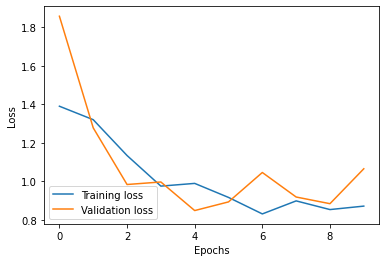

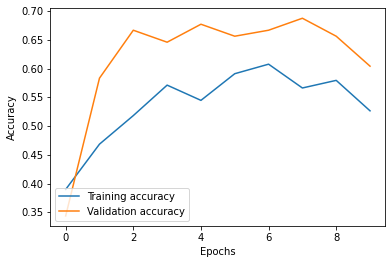

In [0]:
# visualizing losses and accuracy
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accu = hist.history['accuracy']
val_accu = hist.history['val_accuracy']
xc = range(len(train_loss))

plt.figure()
plt.plot(xc, train_loss, label='Training loss')
plt.plot(xc, val_loss, label='Validation loss')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(xc, train_accu, label='Training accuracy')
plt.plot(xc, val_accu, label='Validation accuracy')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### test model

In [0]:
model.load_weights('/content/drive/My Drive/Models_Resnet/ExtraCredit/images_only/model-epoch-008-valacc-0.770833.h5')

In [17]:
test_generator.reset()
ypred = model.predict_generator(test_generator, steps=len(test_generator))
ypred_labels = np.argmax(ypred, axis=1)
ypred_onehot = to_categorical(ypred_labels, num_classes=5)

print('\nTest distribution: ')
print(np.bincount(ypred_labels))
print('\nAccuracy for Resnet50 base + 2 FC layers: ', accuracy_score(y_test_single, ypred_labels))
weather_matrix = confusion_matrix(y_test_single, ypred_labels)
print('\nThe confusion matrix is:')
print(weather_matrix)
print('\n The classification report is: ')
print(classification_report(y_test_single, ypred_labels))

Instructions for updating:
Please use Model.predict, which supports generators.

Test distribution: 
[24 17 14 27 18]

Accuracy for Resnet50 base + 2 FC layers:  0.78

The confusion matrix is:
[[18  2  0  0  0]
 [ 3 15  1  1  0]
 [ 3  0 11  6  0]
 [ 0  0  2 17  1]
 [ 0  0  0  3 17]]

 The classification report is: 
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.88      0.75      0.81        20
           2       0.79      0.55      0.65        20
           3       0.63      0.85      0.72        20
           4       0.94      0.85      0.89        20

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100



## 3. Predictions using tabular + image data models (ensembling)

In [0]:
yPred_decision_norm = yPred_decision/yPred_decision.sum(axis=1,keepdims=True)

In [19]:
svm_wt = 1
nn_wt = 1

final_pred = svm_wt * yPred_decision_norm + nn_wt * ypred
final_pred_labels = np.argmax(final_pred, axis=1)

print('\nTest distribution: ')
print(np.bincount(final_pred_labels))
print('\nAccuracy for ensemble model: ', accuracy_score(y_test_single, final_pred_labels))
weather_matrix = confusion_matrix(y_test_single, final_pred_labels)
print('\nThe confusion matrix is:')
print(weather_matrix)
print('\n The classification report is: ')
print(classification_report(y_test_single, final_pred_labels))


Test distribution: 
[21 21 13 27 18]

Accuracy for ensemble model:  0.82

The confusion matrix is:
[[18  2  0  0  0]
 [ 0 19  0  1  0]
 [ 3  0 11  6  0]
 [ 0  0  2 17  1]
 [ 0  0  0  3 17]]

 The classification report is: 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.90      0.95      0.93        20
           2       0.85      0.55      0.67        20
           3       0.63      0.85      0.72        20
           4       0.94      0.85      0.89        20

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100

